In [33]:
import pandas as pd
import numpy as np
from scipy import spatial
import seaborn as sns
from random import shuffle
import matplotlib.pyplot as plt

In [2]:
def normalizeColumn(column):
    mean = column.mean()
    std = column.std()
    return (column - mean)/ std

In [3]:
dataset = pd.read_csv("../input_data/AdmissionDataset/data.csv")

In [4]:
dataset = dataset.drop('Serial No.', axis = 1)
dataset['GRE Score'] = normalizeColumn(dataset['GRE Score'])
dataset['TOEFL Score'] = normalizeColumn(dataset['TOEFL Score'])
dataset['University Rating'] = normalizeColumn(dataset['University Rating'])
dataset['LOR '] = normalizeColumn(dataset['LOR '])
dataset['CGPA'] = normalizeColumn(dataset['CGPA'])

In [5]:
# Adding bias vector to the dataset with values 1

In [6]:
dataset.insert(loc=0, column='intercept', value=np.ones(len(dataset)))

In [7]:
dataset.head()

,intercept,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1.0,0.040384,-0.690991,-0.988084,2.5,-1.597605,-0.713316,0,0.65
1,1.0,0.216817,0.139084,-0.111086,3.0,0.033837,-0.062724,1,0.71
2,1.0,0.481468,0.471114,-0.111086,3.5,-1.053791,0.154140,1,0.80
3,1.0,0.834335,0.969158,1.642909,4.5,0.577651,1.371916,1,0.91
4,1.0,0.216817,-0.192946,-0.111086,3.5,-1.053791,-0.413043,1,0.74


In [8]:
dataset.keys()

Index(['intercept', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research', 'Chance of Admit '],
      dtype='object')

In [9]:
# Plotting the dataset attributes with respect to output 

In [10]:
def train_validate_test_split(dataset):
    size = len(dataset)
    tsize = int(size*0.8)
    training_data = dataset.iloc[:tsize].reset_index(drop=True)
    testing_data = dataset.iloc[tsize:].reset_index(drop=True)
    return training_data,testing_data

In [11]:
def predict(X,weights):
    return np.dot(X,weights)

In [12]:
def meansquareerror(preds,y):
    return ((preds - y)**2).mean()

In [13]:
def RidgelinearRegressionGD(X,y,weights,lr=0.001,lambdavalue = 0,iteration=1):
    for i in range(iteration):
        preds = predict(X,weights)
        error = meansquareerror(preds,y) + lambdavalue * (np.sum(weights[1:] ** 2))
        weights[0] = weights[0] + lr *error
        for j in range(1,len(X.columns)):
            weights[j] = weights[j] + (lr *error* np.mean(X.iloc[:, [j]].values))
    return weights

In [14]:
def statistics(weights,data):
    X = data.drop('Chance of Admit ',axis=1)
    y = data['Chance of Admit ']
    preds = predict(X,weights)
    cost = meansquareerror(preds,y)
    return cost

In [15]:
training_data, testing_data = train_validate_test_split(dataset)

In [16]:
training_data.index[0]

0

In [17]:
def LOOCV(training_data):
    error_train = error_test = 0
    for k in range(len(training_data)):
        temp_data = training_data
        test = temp_data.iloc[[k]]
        train = temp_data.drop(temp_data.index[[k]])
#         print(train)
        X_train = train.drop('Chance of Admit ',axis=1)
        y_train = train['Chance of Admit ']
        weights = np.zeros((len(X_train.columns)))
        weights= RidgelinearRegressionGD(X_train,y_train,weights,lambdavalue=10,iteration = 10)
        error_train += statistics(weights,train)
        error_test += statistics(weights,test)
    error_train = error_train/len(training_data)
    error_test = error_test
    return error_train, error_test

In [18]:
def k_fold_crossvalidation(training_data, k = 2):
    chunks = np.array_split(training_data,k)
    shuffle(chunks)
    error_train = error_test = 0
    for i in range(k):
        test = chunks[i]
        train = pd.DataFrame({})
        for j in range(k):
            if i != j:
                train = pd.concat([train,chunks[j]], ignore_index=True)  
        X_train = train.drop('Chance of Admit ',axis=1)
        y_train = train['Chance of Admit ']
        weights = np.zeros((len(X_train.columns)))
        weights= RidgelinearRegressionGD(X_train,y_train,weights,lambdavalue=10,iteration = 10)
        error_train += statistics(weights,train)
        error_test += statistics(weights,test)
    error_train = error_train/k
    error_test = error_test/k
    return error_train, error_test, weights

In [23]:
errors = {'k_value':[],
          'train_error':[],
            'test_error':[],
            'validation_error':[]
          }

for k in range(2,10):
    errors['k_value'].append(k)
    error_train, error_val, weights = k_fold_crossvalidation(training_data,k)
    errors['train_error'].append(error_train)
    errors['validation_error'].append(error_val)
    errors['test_error'].append(statistics(weights,testing_data))

In [20]:
LOOCV(training_data)

(0.45035870568815356, 162.1830137195615)

In [31]:
df = pd.DataFrame(errors)

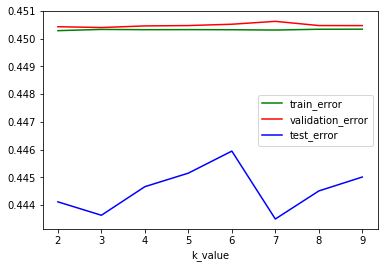

In [36]:
ax = plt.gca()
df.plot(kind='line',x='k_value',y='train_error',color = 'green',ax=ax)
df.plot(kind='line',x='k_value',y='validation_error', color='red', ax=ax)
df.plot(kind='line',x='k_value',y='test_error', color='blue', ax=ax)
plt.show()

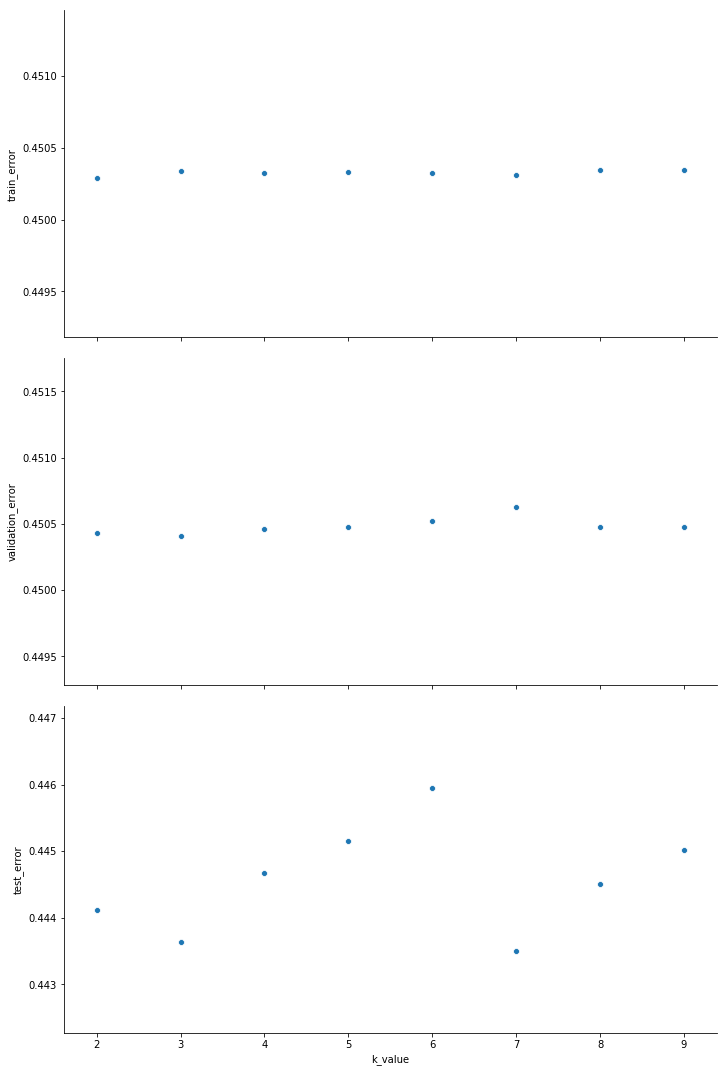

In [26]:
sns.pairplot(pd.DataFrame(errors), x_vars='k_value', y_vars=['train_error','validation_error','test_error',], height=5, aspect=2)

# Observations

- The difference between size of training and resampling subsets decrease with the increasing value of K. This decreasing difference reduce the bias of the model. 
- As in graph it can be seen there is a bias variance trade-off with the value of K. 
- With empirical experiments we can find a K which can give not too high bias and not too high variance. 